In [1]:
import os
import json
import h5py
import pickle
import numpy as np
import pandas as pd 
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization

from sklearn.model_selection import train_test_split

import skimage
from skimage import data, color, exposure

%matplotlib inline

Using TensorFlow backend.


## Method I: ConvNet Heatmap

1. Train classifier
2. Create heatmap
3. Draw bounding boxes

Ref: https://github.com/HTuennermann/Vehicle-Detection-and-Tracking/blob/master/LocalizationModel.ipynb

In [2]:
cars = glob.glob("./data/vehicles/*/*.png")
non_cars = glob.glob("./data/non-vehicles/*/*.png")

# cars are labeled 1, non-cars are labeled -1
Y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))-1])

X = []
for name in cars:    
    X.append(skimage.io.imread(name))
for name in non_cars: 
    X.append(skimage.io.imread(name))
X = np.array(X)

print(Y.shape); print(X.shape)

(17760,)
(17760, 64, 64, 3)


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

train = {'features': X_train, 'labels': y_train}
test = {'features': X_test, 'labels': y_test}

with open("./data/train.p", "wb") as f:
    pickle.dump(train, f)
with open("./data/test.p", "wb") as f:
    pickle.dump(test, f)

In [40]:
def get_conv(input_shape=(64,64,3), filename=None):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    model.add(Convolution2D(10, 3, 3, activation='relu', name='conv1',input_shape=input_shape, 
                            border_mode="same"))
    model.add(Convolution2D(10, 3, 3, activation='relu', name='conv2',border_mode="same"))
    model.add(MaxPooling2D(pool_size=(8,8)))
    model.add(Dropout(0.25))
    model.add(Convolution2D(128,8,8,activation="relu",name="dense1")) # This replaces Dense(128)
    model.add(Dropout(0.5))
    model.add(Convolution2D(1,1,1,name="dense2", activation="tanh")) # This replaces Dense(1)
    if filename:
        model.load_weights(filename)
    return model

model = get_conv()
model.add(Flatten())
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_5 (Lambda)                (None, 64, 64, 3)     0           lambda_input_5[0][0]             
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 64, 64, 10)    280         lambda_5[0][0]                   
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, 64, 64, 10)    910         conv1[0][0]                      
____________________________________________________________________________________________________
maxpooling2d_4 (MaxPooling2D)    (None, 8, 8, 10)      0           conv2[0][0]                      
___________________________________________________________________________________________

In [41]:
if not os.path.exists("./output"): 
    os.makedirs("./output")

checkpointer = ModelCheckpoint("./output/model_heat.hdf5", verbose=1, save_best_only=True)

model.fit(X_train, y_train, 
          batch_size=128, nb_epoch=20, verbose=1, 
          validation_data=(X_test, y_test),
          callbacks=[checkpointer])

Train on 14208 samples, validate on 3552 samples
Epoch 1/20
14208/14208 [==============================] - 37s - loss: 0.4517 - acc: 0.5600 - val_loss: 0.2160 - val_acc: 0.8421
Epoch 2/20
14208/14208 [==============================] - 37s - loss: 0.1774 - acc: 0.8725 - val_loss: 0.1288 - val_acc: 0.9167
Epoch 3/20
14208/14208 [==============================] - 37s - loss: 0.1255 - acc: 0.9110 - val_loss: 0.1016 - val_acc: 0.9310
Epoch 4/20
14208/14208 [==============================] - 39s - loss: 0.0884 - acc: 0.9418 - val_loss: 0.0729 - val_acc: 0.9564
Epoch 5/20
14208/14208 [==============================] - 38s - loss: 0.0810 - acc: 0.9507 - val_loss: 0.0703 - val_acc: 0.9589
Epoch 6/20
14208/14208 [==============================] - 37s - loss: 0.0628 - acc: 0.9595 - val_loss: 0.0618 - val_acc: 0.9626
Epoch 7/20
14208/14208 [==============================] - 37s - loss: 0.0530 - acc: 0.9646 - val_loss: 0.0502 - val_acc: 0.9662
Epoch 8/20
14208/14208 [==============================]

In [42]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.023294422722
Test accuracy: 0.985641891892


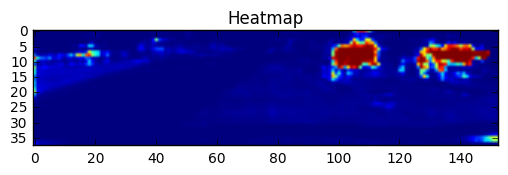

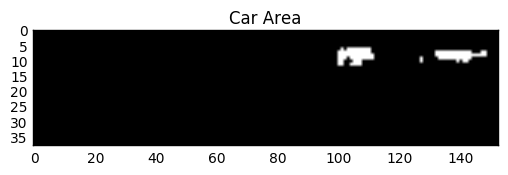

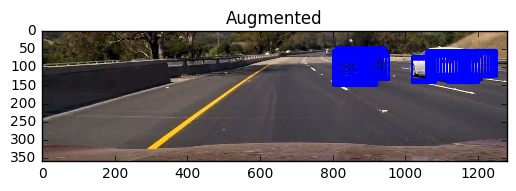

In [61]:
model_heat = get_conv(input_shape=(None,None,3), filename="./output/model_heat.hdf5")


def locate(file = "./test_images/test6.jpg"):
    data = (skimage.io.imread(file))
    data = data[int(data.shape[0]/2):,:,:]
    
    heatmap = model_heat.predict(data.reshape(1,data.shape[0],data.shape[1],data.shape[2]))
    
    plt.imshow(heatmap[0,:,:,0])
    plt.title("Heatmap")
    plt.show()
    plt.imshow(heatmap[0,:,:,0]>0.99, cmap="gray")
    plt.title("Car Area")
    plt.show()

    xx, yy = np.meshgrid(np.arange(heatmap.shape[2]),np.arange(heatmap.shape[1]))
    x = (xx[heatmap[0,:,:,0]>0.99])
    y = (yy[heatmap[0,:,:,0]>0.99])
    
    for i,j in zip(x,y):
        cv2.rectangle(data, (i*8,j*8), (i*8+64,j*8+64), (0,0,255), 5)
    return data

annotated = locate()

plt.title("Augmented")    
plt.imshow(annotated)
plt.show()

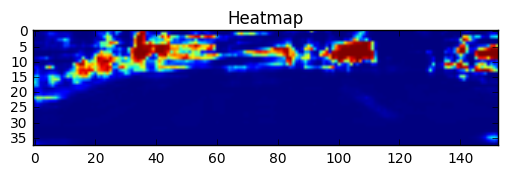

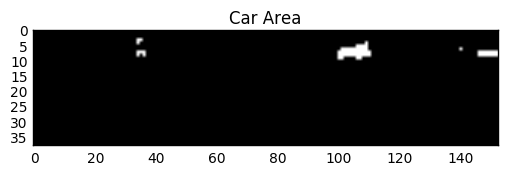

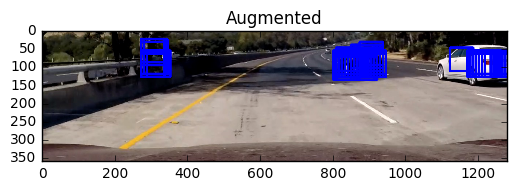

In [62]:
annotated = locate("./test_images/test5.jpg")

plt.title("Augmented")
plt.imshow(annotated)
plt.show()

## Method II: U-net

Ref: https://github.com/jocicmarko/ultrasound-nerve-segmentation

In [1]:
import cv2
import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
K.set_image_dim_ordering('tf')  # Theano dimension ordering in this code
import pandas as pd
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import pickle

%matplotlib inline

h, w, c = 1200, 1920, 3

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def get_unet():

    inputs = Input((h, w, c))
    conv1 = Convolution2D(4, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(4, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=3)
    conv6 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=3)
    conv7 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=3)
    conv8 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=3)
    conv9 = Convolution2D(4, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(4, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

Using TensorFlow backend.


In [4]:
myModel = get_unet()
myModel.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1200, 1920, 3) 0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 1200, 1920, 4) 112         input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 1200, 1920, 4) 148         convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 600, 960, 4)   0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [5]:
tb = pd.read_csv('./object-detection-crowdai/labels.csv').dropna()
tb_cars = tb[tb['Label']=='Car'].reset_index(drop=True)
tb_cars.head()

,xmin,xmax,ymin,ymax,Frame,Label,Preview URL
0,785,533,905,644,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
1,89,551,291,680,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
2,268,546,383,650,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
3,1726,484,1919,646,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
4,758,557,807,617,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...


In [6]:
print(tb_cars.shape)

(62570, 7)


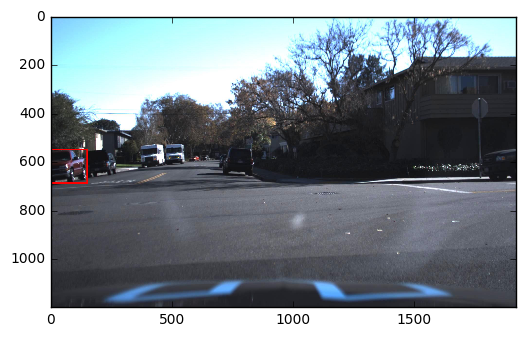

In [7]:
img = mpimg.imread(os.path.join('./object-detection-crowdai', tb_cars['Frame'][10]))
xmin, ymin, xmax, ymax = tb['xmin'][10], tb['xmax'][10], tb['ymin'][10], tb['ymax'][10]
img_ = cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
plt.imshow(img_)

In [8]:
tb_cars = tb_cars.reindex(np.random.permutation(np.arange(tb_cars.shape[0]))).reset_index(drop=True)
tb_cars.head()

,xmin,xmax,ymin,ymax,Frame,Label,Preview URL
0,505,589,627,660,1479503250297446922.jpg,Car,http://crowdai.com/images/P4vwN-2hKnwQTfGQ/vis...
1,650,553,694,587,1479504983411684511.jpg,Car,http://crowdai.com/images/XClIYqiJzPeqNhZv/vis...
2,1129,559,1215,624,1479499520022148771.jpg,Car,http://crowdai.com/images/NmFs5WNGjAnhTNw_/vis...
3,802,537,852,579,1479499712555471646.jpg,Car,http://crowdai.com/images/0YWSvqp-eqyPgeCj/vis...
4,452,558,627,636,1479500265093903475.jpg,Car,http://crowdai.com/images/3XFACZ61DdAawyDF/vis...


In [9]:
def udf(row):
    return list(zip( list(row['xmin']), list(row['xmax']), list(row['ymin']), list(row['ymax']) ))

tb_cars_ = tb_cars[['xmin','xmax','ymin','ymax','Frame']].groupby('Frame').apply(udf)
tb_cars_.head()

Frame
1479498371963069978.jpg    [(758, 557, 807, 617), (89, 551, 291, 680), (6...
1479498372942264998.jpg    [(710, 540, 836, 665), (613, 561, 651, 599), (...
1479498373462797835.jpg    [(550, 582, 595, 607), (600, 580, 637, 603), (...
1479498373962951201.jpg    [(573, 586, 613, 617), (655, 557, 790, 698), (...
1479498374962942172.jpg    [(287, 614, 335, 643), (338, 609, 379, 640), (...
dtype: object

In [10]:
print(tb_cars_.index[0])
print(tb_cars_.values[0])
print(tb_cars_.shape)

1479498371963069978.jpg
[(758, 557, 807, 617), (89, 551, 291, 680), (682, 557, 718, 593), (785, 533, 905, 644), (633, 561, 680, 597), (1726, 484, 1919, 646), (268, 546, 383, 650)]
(9130,)


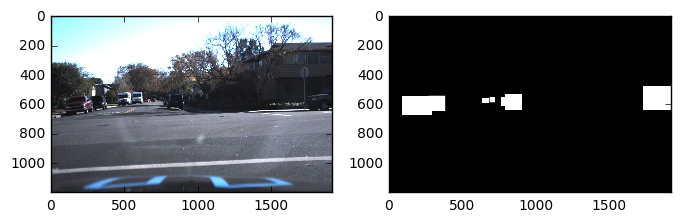

In [11]:
img = mpimg.imread(os.path.join('./object-detection-crowdai', tb_cars_.index[0]))
masked = np.zeros_like(img)
for p in tb_cars_.values[0]:
    masked[p[1]:p[3], p[0]:p[2], :] = 255
masked = cv2.cvtColor(masked, cv2.COLOR_RGB2GRAY) # 0 to 1
fig = plt.figure(figsize=(8,16))
ax = fig.add_subplot(1,2,1)
ax = plt.imshow(img)
ax = fig.add_subplot(1,2,2)
ax = plt.imshow(masked, cmap='gray')

In [13]:
def sample_train_test(series, n = 500):
    
    img_list, mask_list = [], []
    
    tot = len(series.index)
    
    for i in np.random.choice(np.arange(tot), n, replace = False):
        
        img = mpimg.imread(os.path.join('./object-detection-crowdai', series.index[i]))
        
        mask = np.zeros_like(img[:,:,0])
        
        for p in series.values[i]:
            mask[p[1]:p[3], p[0]:p[2]] = 1
        
        mask = np.expand_dims(mask, axis=2) # shape: [1200, 1290, 1], 0 and 1
        img_list.append(img)
        mask_list.append(mask)
    
    img_train, img_test, mask_train, mask_test = train_test_split(img_list, mask_list, test_size=0.1)
    
    train = {'img': np.array(img_train), 'mask': np.array(mask_train)}
    test = {'img': np.array(img_test), 'mask': np.array(mask_test)}
    return train, test

In [14]:
t0 = time.time()
train, test = sample_train_test(tb_cars_, n=100)
t1 = time.time()
print(t1-t0)

8.901561975479126


In [17]:
def gen_train(dat, batch_size = 16):
    
    batch_images = np.zeros((batch_size, h, w, 3), dtype=np.uint8)
    batch_masks = np.zeros((batch_size, h, w, 1), dtype=np.uint8)
    
    cursor = 0
    
    while True:
        for i in np.arange(batch_size):
            cursor = cursor % dat['img'].shape[0]
            batch_images[i], batch_masks[i] = dat['img'][cursor], dat['mask'][cursor]
            cursor += 1
        yield batch_images, batch_masks
        
def load_train_data():
    with open('./data/train_cars.p', mode = 'rb') as f:
        train = pickle.load(f)
    return {'img': train['img'], 'mask': train['mask']}

train_batch = gen_train(train, batch_size = 16)
batch = next(train_batch)
print((batch[0].shape))

(16, 1200, 1920, 3)


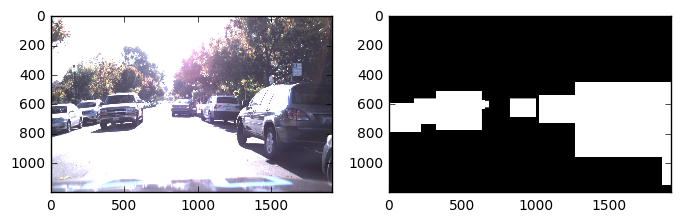

In [17]:
batch = next(train_batch)
fig = plt.figure(figsize=(8,16))
ax = fig.add_subplot(1,2,1)
ax = plt.imshow(batch[0][0,])
ax = fig.add_subplot(1,2,2)
ax = plt.imshow(batch[1][0,:,:,-1], cmap='gray')

In [26]:
model = get_unet()
model_checkpoint = ModelCheckpoint('./output/model_unet_temp.hdf5', monitor='loss', save_best_only=True)

model.fit(train['img'][:50,], train['mask'][:50,], batch_size=8, nb_epoch=5, verbose=1, shuffle=True,
          callbacks=[model_checkpoint])

Epoch 1/5
50/50 [==============================] - 202s - loss: -0.1418 - dice_coef: 0.1418     
Epoch 2/5
50/50 [==============================] - 202s - loss: -0.1518 - dice_coef: 0.1518     

In [3]:
model = get_unet()
model.load_weights('./output/model_unet_temp.hdf5')

In [15]:
pred = model.predict(test['img'])

In [30]:
k = 3

img = test['img'][k,] # k-th image
mask_pred = np.array(255*pred[k],dtype=np.uint8) # k-th prediction
mask_pred = cv2.cvtColor(mask_pred,cv2.COLOR_GRAY2RGB)
mask_pred[:,:,1:3] = 0*mask_pred[:,:,1:2]

img_pred = cv2.addWeighted(mask_pred, 0.7, img, 0.3, 0)

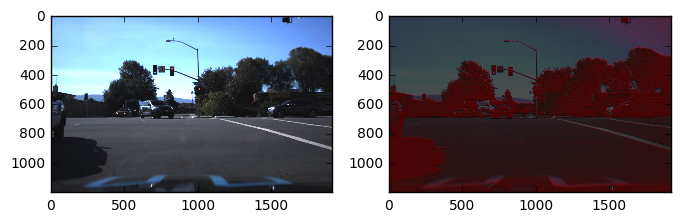

In [31]:
fig = plt.figure(figsize=(8,16))
ax = fig.add_subplot(1,2,1)
ax = plt.imshow(img) 
ax = fig.add_subplot(1,2,2)
ax = plt.imshow(img_pred)

In [32]:
from six.moves import cPickle as pickle 

In [33]:
with open("./data/train_cars.p", "wb") as f:
    pickle.dump(train, f)
with open("./data/test_cars.p", "wb") as f:
    pickle.dump(test, f)

In [34]:
t0 = time.time()
train, test = sample_train_test(tb_cars_, n=1000)
t1 = time.time()
print(t1-t0)

111.71784615516663


In [ ]:
with open("./data/train_cars.p", "wb") as f:
    pickle.dump(train, f, protocol=4)
with open("./data/test_cars.p", "wb") as f:
    pickle.dump(test, f, protocol=4)